In [0]:


import gdown
url= 'https://drive.google.com/uc?id=1RXx2j_czrARBNMS1vc2WT-oL-9iWT_PA'
gdown.download(url,'GloVe',quiet= False)
url = 'https://drive.google.com/uc?id=1IQq0XAWSOv0XiyORnaxHKQqkeDPp-Q2A'
gdown.download(url,'train.csv',quiet= False)
url = 'https://drive.google.com/uc?id=1OeJ5_KhbzJtv_HxfdjQ5IBZYQ9_HEuLX'
gdown.download(url,'test_labels.csv',quiet= False)
url = 'https://drive.google.com/uc?id=15Pvx6xXa2uPuePSZOXtvtbuTnPixM--r'
gdown.download(url,'test.csv',quiet= False)

Downloading...
From: https://drive.google.com/uc?id=1RXx2j_czrARBNMS1vc2WT-oL-9iWT_PA
To: /content/GloVe
862MB [00:05, 154MB/s]
Downloading...
From: https://drive.google.com/uc?id=1IQq0XAWSOv0XiyORnaxHKQqkeDPp-Q2A
To: /content/train.csv
68.8MB [00:00, 144MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1OeJ5_KhbzJtv_HxfdjQ5IBZYQ9_HEuLX
To: /content/test_labels.csv
4.98MB [00:00, 183MB/s]
Downloading...
From: https://drive.google.com/uc?id=15Pvx6xXa2uPuePSZOXtvtbuTnPixM--r
To: /content/test.csv
60.4MB [00:00, 124MB/s] 


'test.csv'

In [0]:
import os 
import zipfile
with zipfile.ZipFile('GloVe','r')as zipref:
  zipref.extractall('data/')

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import seaborn as sns

In [0]:
test_labels = pd.read_csv('test_labels.csv')
print(test_labels.shape)
test_labels.head(2)

(153164, 7)


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1


In [0]:
test_labels = test_labels[(test_labels[['toxic','severe_toxic', 'obscene', 'threat', 
                                        'insult', 'identity_hate']] != -1).all(axis=1)]
print(test_labels.shape)
test_labels.head(2)

(63978, 7)


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,0,0,0,0,0,0
7,000247e83dcc1211,0,0,0,0,0,0


In [0]:
df_test = pd.read_csv('test.csv')
print(df_test.shape)
df_test.head(2)

(153164, 2)


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...


In [0]:
test = pd.merge(test_labels, df_test, on='id', how='inner')
print(test.shape)
test.head(2)

(63978, 8)


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
0,0001ea8717f6de06,0,0,0,0,0,0,Thank you for understanding. I think very high...
1,000247e83dcc1211,0,0,0,0,0,0,:Dear god this site is horrible.


In [0]:
train = pd.read_csv('train.csv')
train.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0


In [0]:
# check the number of records
print('The dataset contains', train.shape[0], 'records and', train.shape[1], 'columns.')

The dataset contains 159571 records and 8 columns.


In [0]:
# check that there are no missing values in either training set
print('The dataset has', train.isna().sum().sum(), 'missing values.')

The dataset has 0 missing values.


In [0]:
# check if there are any duplicates
print('The dataset has', train.duplicated().sum(), 'duplicates.')

The dataset has 0 duplicates.


Preprocessing the Data


In [0]:
# importing libraries
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence

Using TensorFlow backend.


In [0]:
X_train = train["comment_text"].values
X_test  = test["comment_text"].values

y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
y_test  = test[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

In [0]:
# tokenizing the data
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X_train))

# turning the tokenized text into sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

# padding the sequences
X_train = sequence.pad_sequences(X_train, maxlen=200)
X_test  = sequence.pad_sequences(X_test,  maxlen=200)

print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape: (159571, 200)
X_test shape:  (63978, 200)


Evaluating Different Neural Networks

Deep learning models - or neural networks - have achieved state-of-the-art results in text classification problems. Here we work through different neural networks to compare their results.

We'll start with three deep learning models that use their own trained embedding layer, and then try two algorithms that use pre-trained embeddings.

In [0]:
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, Activation
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization
from keras.optimizers import Adam

In [0]:
max_features = 20000 

# max number of words in a comment to use (or: number of columns in incoming embedding vector)
max_len = 200 

# dimension of the embedding variable (or: number of rows in output of embedding vector)
embedding_dims = 128

Baseline Neural Network

Let's start with instantiating a classic densely connected neural network to create a strong baseline. It's composed of several layers:

The input layer  is the first layer in the neural network. It takes input values and passes them on to the next layer without applying any operations to them. We begin by defining an input layer that accepts a list of words with a dimension of 200 (= max words in one comment).

Next, we pass our vectors to an embedding layer, where we project the words onto a defined vector space depending on the distance of the surrounding words in a sentence. Embedding allows us to reduce model size, and most importantly the huge dimensions we have to deal with.

The output of the embedding layer is just a list of the coordinates of the words in this vector space. We need to define the size of this vector space and the number of unique words we are using. It's important to know that the embedding size is a parameter that one can tune and experiment with.

A pooling layer effectively downsamples the output of the prior layer, reducing the number of operations required for all following layers, but still passing on the valid information from the previous layer.

Dense layers (or fully connected layers) are simply a linear operation in which every input is connected to every output by a weight, generally followed by a non-linear activation function.

Regularization  layers are used to overcome the over-fitting problem. In regularization we either penalise our loss term by adding a L1 (LASSO) or an L2 (Ridge) norm on the weight vector. Alternatively, we can apply a dropout layer where individual nodes are dropped out of the net, so that a reduced network is left.

Finally, the output layer  is the last layer in the network and receives its input from the last hidden layer. With this layer we can get the desired number of values in a desired range. In our network we have 6 neurons in the output layer.

Activation functions are used to introduce non-linearity to neural networks. They squash the values into a smaller range. There are many activation functions used in the deep learning industry such as ReLU, Sigmoid or TanH.

In [0]:
# instantiate NN model
base_model = Sequential()

# add embedding layer 
base_model.add(Embedding(input_dim=max_features, input_length=max_len,
                         output_dim=embedding_dims))

# add pooling layer 
# ... which will extract features from the embeddings of all words in the comment
base_model.add(GlobalMaxPool1D())

# add dense layer to produce an output dimension of 50 and apply relu activation
base_model.add(Dense(50, activation='relu'))

# set the regularizing dropout layer to drop out 30% of the nodes
base_model.add(Dropout(0.3))

# finally add a dense layer
# ... which projects output into six units and squash it with sigmoid activation
base_model.add(Dense(6, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Next, we compile the network:

The loss function computes the error for a single training example. The cost function is the average of the loss functions of the entire training set. Our choice here is categorical_crossentropy, i.e. a multi-class logarithmic loss.
When we train neural networks, we usually use Gradient Descent to optimize the weights. At each iteration, we use back-propagation to calculate the derivative of the loss function with respect to each weight and subtract it from that weight. The learning rate determines how quickly or how slowly we want to update our weight values. It should be just high enough to take an acceptable time to converge, and just low enough to be capable of finding the local minima.
The optimizer is a search technique, which is used to update weights in the model. Our choice here is Adaptive Moment Estimation (Adam) which uses adaptive learning rates.
Performance metrics are used to measure the performance of the neural network. Accuracy, loss, validation accuracy, validation loss, mean absolute error, precision, recall and f1 score are some performance metrics. Our choice here is accuracy.

In [0]:
base_model.compile(loss='binary_crossentropy',
                   optimizer=Adam(0.01), metrics=['accuracy'])

# check the model with all our layers
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6450      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total params: 2,566,756
Trainable params: 2,566,756
Non-trainable params: 0
_________________________________________________________________


Finally, we train the network with some parameters:

The batch size is the number of training examples in one forward/backward pass. In general, larger batch sizes result in faster progress in training, but don't always converge as quickly. Smaller batch sizes train slower, but can converge faster. And the higher the batch size, the more memory space you’ll need.

The training epochs  are the number of times that the model is exposed to the training dataset. One epoch equals one forward pass and one backward pass of all the training examples. In general, the models improve with more epochs of training, to a point. They'll start to plateau in accuracy as they converge.

In [0]:
base_hist = base_model.fit(X_train, y_train, batch_size=32, 
                           epochs=3, validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 143613 samples, validate on 15958 samples
Epoch 1/3
143613/143613 [==============================] - 243s 2ms/step - loss: 0.0657 - acc: 0.9781 - val_loss: 0.0555 - val_acc: 0.9797
Epoch 2/3
143613/143613 [==============================] - 240s 2ms/step - loss: 0.0549 - acc: 0.9800 - val_loss: 0.0585 - val_acc: 0.9783
Epoch 3/3
143613/143613 [==============================] - 239s 2ms/step - loss: 0.0526 - acc: 0.9803 - val_loss: 0.0649 - val_acc: 0.9809


In [0]:
print(base_hist.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


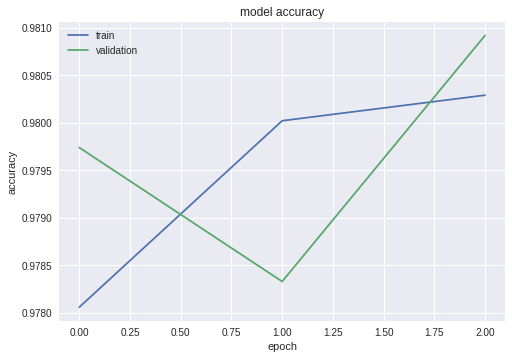

In [0]:

#  "Accuracy"
plt.plot(base_hist.history['acc'])
plt.plot(base_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


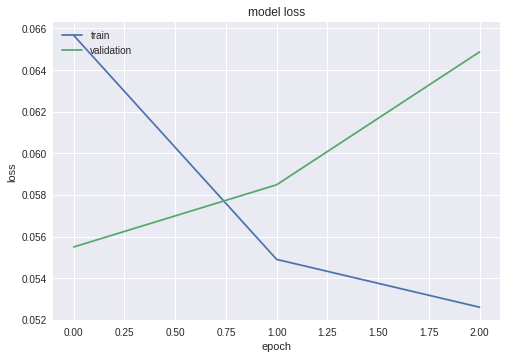

In [0]:
# "Loss"
plt.plot(base_hist.history['loss'])
plt.plot(base_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Seems that the accuracy is pretty decent for a basic attempt!

In [0]:
# evaluate the algorithm on the test dataset
base_test_loss, base_test_auc = base_model.evaluate(X_test, y_test, batch_size=32)
print('Test Loss:    ', base_test_loss)
print('Test Accuracy:', base_test_auc)

63978/63978 [==============================] - 3s 46us/step
Test Loss:     0.07868262833659653
Test Accuracy: 0.9715865740756982


Convolutional Neural Network (CNN)

Convolutional neural networks (CNN's) recently proved to be very effective at document classification, namely because they are able to pick out salient features (e.g. tokens or sequences of tokens) in a way that is invariant to their position within the input sequences. Simply put, a convolution is a sliding window function applied to a matrix. To set up a CNN, we have to add a convolutional layer:

A convolutional layer consists of a set of “filters”. These filters only take in a subset of the input data at a given time, but are applied across the full input by sweeping over it. The operations performed here are still linear, but they are generally followed by a non-linear activation function.
Furthermore, I took a piece of advice I found here.: "As many competitors pointed out, dropout and batch-normalization are the keys to prevent overfitting and dropout did a better job. By applying the dropout on the word embedding directly and behind the pooling does great regularization both on train set and test set. "

A batch normalization layer normalizes the activations of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. It will be added after the activation function between a convolutional and a max-pooling layer. This website provides great advice for implementing such a layer.

In [0]:
# instantiate CNN model
cnn_model = Sequential()

# add embedding layer 
cnn_model.add(Embedding(input_dim=max_features, input_length=max_len,
                        output_dim=embedding_dims))
 
# set the dropout layer to drop out 50% of the nodes
cnn_model.add(SpatialDropout1D(0.5))

# add convolutional layer that has ...
# ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
cnn_model.add(Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'))

# add normalization layer
cnn_model.add(BatchNormalization())

# add pooling layer 
cnn_model.add(GlobalMaxPool1D())

# set the dropout layer to drop out 50% of the nodes
cnn_model.add(Dropout(0.5))

# add dense layer to produce an output dimension of 50 and using relu activation
cnn_model.add(Dense(50, activation='relu'))

# finally add a dense layer
cnn_model.add(Dense(6, activation='sigmoid'))

In [0]:
cnn_model.compile(loss='binary_crossentropy',
                  optimizer=Adam(0.01),
                  metrics=['accuracy'])

cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 100)          51300     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 100)          400       
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
__________

In [0]:
cnn_hist = cnn_model.fit(X_train, y_train, batch_size=32, 
                         epochs=3, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/3
143613/143613 [==============================] - 502s 3ms/step - loss: 0.0756 - acc: 0.9753 - val_loss: 0.0572 - val_acc: 0.9797
Epoch 2/3
143613/143613 [==============================] - 501s 3ms/step - loss: 0.0573 - acc: 0.9798 - val_loss: 0.0622 - val_acc: 0.9800
Epoch 3/3
143613/143613 [==============================] - 498s 3ms/step - loss: 0.0542 - acc: 0.9805 - val_loss: 0.0549 - val_acc: 0.9808


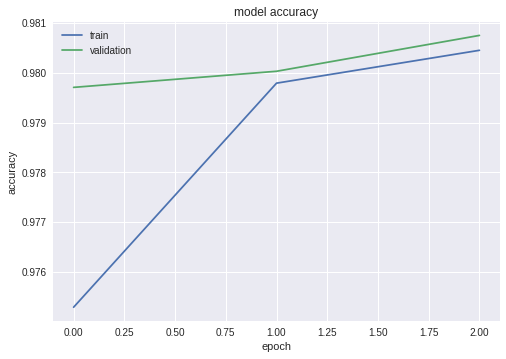

In [0]:
#  "Accuracy"
plt.plot(cnn_hist.history['acc'])
plt.plot(cnn_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

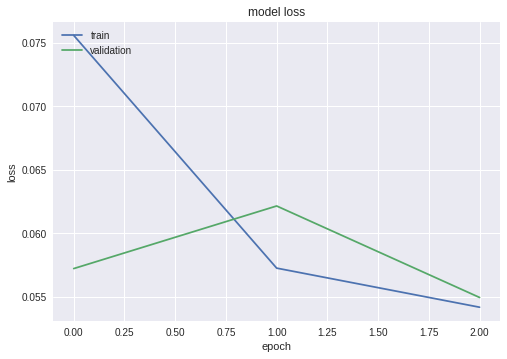

In [0]:
# "Loss"
plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Well, the validation accuracy is 0.02% worse than in our basic neural network.

As a side note: I first ran this algorithm without batch normalization and had a training accuracy of 0.9736 and a validation accuracy of 0.9748. Now, with batch normalization, both training and validation accuracy have increased slightly - to 0.9807 and 0.9805 respectively!

In [0]:
cnn_test_loss, cnn_test_auc = cnn_model.evaluate(X_test, y_test, batch_size=32)
print('Test Loss:    ', cnn_test_loss)
print('Test Accuracy:', cnn_test_auc)

63978/63978 [==============================] - 46s 721us/step
Test Loss:     0.07565957289788262
Test Accuracy: 0.970638333308946


Recurrent Neural Network (RNN)

Recurrent Neural Networks (RNNs) are popular models that have shown great promise in many NLP tasks. The idea behind RNNs is to make use of sequential information. In a traditional neural network we assume that all inputs (and outputs) are independent of each other. But for many tasks, that’s a very bad idea. If you want to predict the next word in a sentence, you had better know which words came before it. RNNs are called recurrent because they perform the same task for every element of a sequence, with the output being dependent on the previous computations. 
Another way to think about RNNs is that they have a “memory” which captures information about what has been calculated so far. In theory, RNNs can make use of information in arbitrarily long sequences, but in practice they are limited to looking back only a few steps.

Bidirectional RNNs are based on the idea that the output at a given point in time may not only depend on the previous elements in the sequence, but also future elements. For example, to predict a missing word in a sequence you will want to look at the context on both the left and the right. 
Bidirectional RNNs are quite simple. They are just two RNNs stacked on top of each other with a twist: half of the neurons start at the beginning of the data and work towards the end one step at a time, while the other half start at the end of the data and work towards the beginning at the same pace.

In [0]:
# instantiate RNN model
rnn_model = Sequential()

# add embedding layer 
rnn_model.add(Embedding(input_dim=max_features, input_length=max_len,
                        output_dim=embedding_dims))

# set the dropout layer to drop out 50% of the nodes
rnn_model.add(SpatialDropout1D(0.5))

# add bidirectional layer and pass in an LSTM()
rnn_model.add(Bidirectional(LSTM(25, return_sequences=True)))

# add normalization layer
rnn_model.add(BatchNormalization())

# add pooling layer 
rnn_model.add(GlobalMaxPool1D())

# set the dropout layer to drop out 50% of the nodes
rnn_model.add(Dropout(0.5))

# add dense layer to produce an output dimension of 50 and using relu activation
rnn_model.add(Dense(50, activation='relu'))

# finally add a dense layer
rnn_model.add(Dense(6, activation='sigmoid'))

In [0]:
rnn_model.compile(loss='binary_crossentropy',
                  optimizer=Adam(0.01),
                  metrics=['accuracy'])

rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 50)           30800     
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 50)           200       
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 50)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
__________

In [0]:
rnn_hist = rnn_model.fit(X_train, y_train, batch_size=32, 
                          epochs=3, validation_split=0.2)

Train on 127656 samples, validate on 31915 samples
Epoch 1/3
127656/127656 [==============================] - 1235s 10ms/step - loss: 0.0732 - acc: 0.9758 - val_loss: 0.0570 - val_acc: 0.9809
Epoch 2/3
127656/127656 [==============================] - 1223s 10ms/step - loss: 0.0632 - acc: 0.9783 - val_loss: 0.0560 - val_acc: 0.9808
Epoch 3/3
127656/127656 [==============================] - 1225s 10ms/step - loss: 0.0631 - acc: 0.9783 - val_loss: 0.0569 - val_acc: 0.9806


We face a slight increase in validation accuracy!

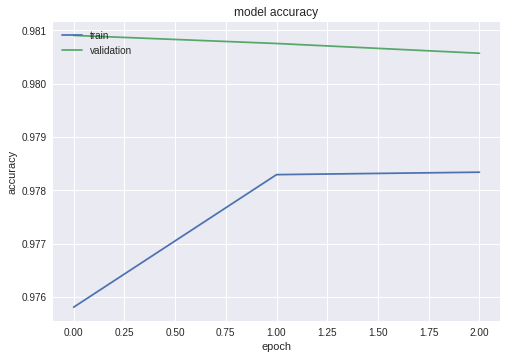

In [0]:
#  "Accuracy"
plt.plot(rnn_hist.history['acc'])
plt.plot(rnn_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

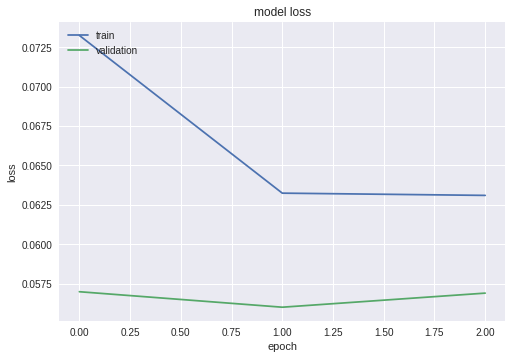

In [0]:
# "Loss"
plt.plot(rnn_hist.history['loss'])
plt.plot(rnn_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
rnn_test_loss, rnn_test_auc = rnn_model.evaluate(X_test, y_test, batch_size=32)
print('Test Loss:    ', rnn_test_loss)
print('Test Accuracy:', rnn_test_auc)

63978/63978 [==============================] - 125s 2ms/step
Test Loss:     0.07348328677140194
Test Accuracy: 0.9717533004288004


CNN with Pre-Trained GloVe Embedding

Making use of weights from a Word2Vec model that has been trained for a very long time on a massive amount of text data might be a good way to improve the performance of text classification. With deep learning, more data is almost always the single best way that to improve a model's performance - and the embedded word vectors created by a Word2Vec model are no exception. For this reason, it's a good idea to load one of the top-tier, industry-standard models that has been open sourced for this exact purpose.

Let's now explore the other way to add an embedding layer to our neural network by using a pre-trained embedding layer. We'll go with the GloVe method, first with a CNN and eventually an RNN.

In [0]:
# load the glove6B embedding

embeddings_index = dict()
f = open('/content/data/glove.6B.300d.txt')

for line in f:
    # Note: use split(' ') instead of split() if you get an error
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [0]:
# create a weight matrix
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

A pretrained embedding requires the arguments weights=embedding_matrix as well as trainable=False to freeze the weights.

In [0]:
# instantiate pretrained glove model
glove_model = Sequential()

# add embedding layer 
glove_model.add(Embedding(input_dim =embedding_matrix.shape[0], input_length=max_len,
                          output_dim=embedding_matrix.shape[1], 
                          weights=[embedding_matrix], trainable=False))
 
# set the dropout layer to drop out 50% of the nodes
glove_model.add(SpatialDropout1D(0.5))

# add convolutional layer that has ...
# ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
glove_model.add(Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'))

# add normalization layer
glove_model.add(BatchNormalization())

# add pooling layer 
glove_model.add(GlobalMaxPool1D())

# set the dropout layer to drop out 50% of the nodes
glove_model.add(Dropout(0.5))

# add dense layer to produce an output dimension of 50 and using relu activation
glove_model.add(Dense(50, activation='relu'))

# finally add a dense layer
glove_model.add(Dense(6, activation='sigmoid'))


In [0]:
glove_model.compile(loss='binary_crossentropy',
                    optimizer=Adam(0.01),
                    metrics=['accuracy'])

glove_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 300)          63101400  
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 200, 300)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 100)          120100    
_________________________________________________________________
batch_normalization_3 (Batch (None, 200, 100)          400       
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 100)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050      
__________

As expected from a pretrained model with frozen weights, we only have a few trainable parameters left!

In [0]:
glove_hist = glove_model.fit(X_train, y_train, batch_size=32, 
                             epochs=3, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/3
143613/143613 [==============================] - 588s 4ms/step - loss: 0.0900 - acc: 0.9726 - val_loss: 0.0607 - val_acc: 0.9786
Epoch 2/3
143613/143613 [==============================] - 593s 4ms/step - loss: 0.0720 - acc: 0.9760 - val_loss: 0.0591 - val_acc: 0.9790
Epoch 3/3
143613/143613 [==============================] - 572s 4ms/step - loss: 0.0690 - acc: 0.9766 - val_loss: 0.0601 - val_acc: 0.9781


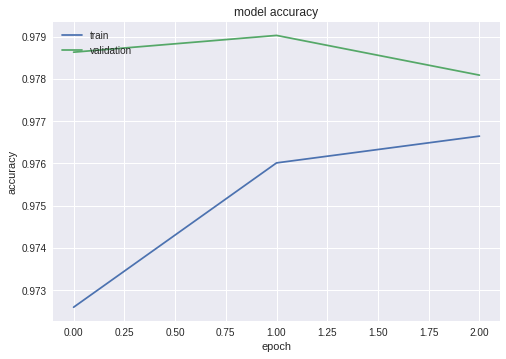

In [0]:
#  "Accuracy"
plt.plot(glove_hist.history['acc'])
plt.plot(glove_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

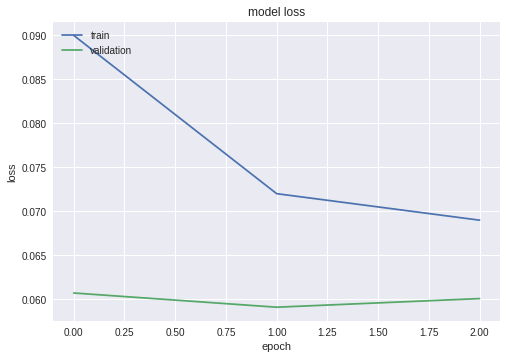

In [0]:
# "Loss"
plt.plot(glove_hist.history['loss'])
plt.plot(glove_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

This algorithm did not improve the RNN's accuracy.

In [0]:
glove_test_loss, glove_test_auc = glove_model.evaluate(X_test, y_test, batch_size=32)
print('Test Loss:    ', glove_test_loss)
print('Test Accuracy:', glove_test_auc)

63978/63978 [==============================] - 114s 2ms/step
Test Loss:     0.07212525785380185
Test Accuracy: 0.9727067521645556


 RNN with Pre-Trained GloVe Embedding

In [0]:
# instantiate pretrained glove model
glove_2_model = Sequential()

# add embedding layer 
glove_2_model.add(Embedding(input_dim =embedding_matrix.shape[0], input_length=max_len,
                          output_dim=embedding_matrix.shape[1], 
                          weights=[embedding_matrix], trainable=False))

# set the dropout layer to drop out 50% of the nodes
glove_2_model.add(SpatialDropout1D(0.5))

# add bidirectional layer and pass in an LSTM()
glove_2_model.add(Bidirectional(LSTM(25, return_sequences=True)))

# add normalization layer
glove_2_model.add(BatchNormalization())

# add pooling layer 
glove_2_model.add(GlobalMaxPool1D())

# set the dropout layer to drop out 50% of the nodes
glove_2_model.add(Dropout(0.5))

# add dense layer to produce an output dimension of 50 and using relu activation
glove_2_model.add(Dense(50, activation='relu'))

# finally add a dense layer
glove_2_model.add(Dense(6, activation='sigmoid'))

In [0]:
glove_2_model.compile(loss='binary_crossentropy',
                    optimizer=Adam(0.01),
                    metrics=['accuracy'])

glove_2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 300)          63101400  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 200, 300)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 50)           65200     
_________________________________________________________________
batch_normalization_4 (Batch (None, 200, 50)           200       
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 50)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                2550      
__________

In [0]:
glove_2_hist = glove_2_model.fit(X_train, y_train, batch_size=32, 
                                 epochs=3, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/3
143613/143613 [==============================] - 1367s 10ms/step - loss: 0.0841 - acc: 0.9727 - val_loss: 0.0637 - val_acc: 0.9785
Epoch 2/3
143613/143613 [==============================] - 1364s 9ms/step - loss: 0.0739 - acc: 0.9757 - val_loss: 0.0637 - val_acc: 0.9785
Epoch 3/3
143613/143613 [==============================] - 1356s 9ms/step - loss: 0.0725 - acc: 0.9758 - val_loss: 0.0611 - val_acc: 0.9787


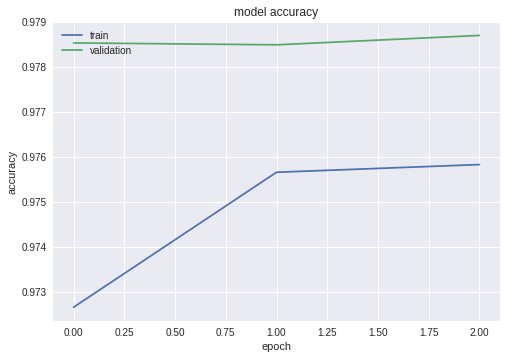

In [0]:
#  "Accuracy"
plt.plot(glove_2_hist.history['acc'])
plt.plot(glove_2_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

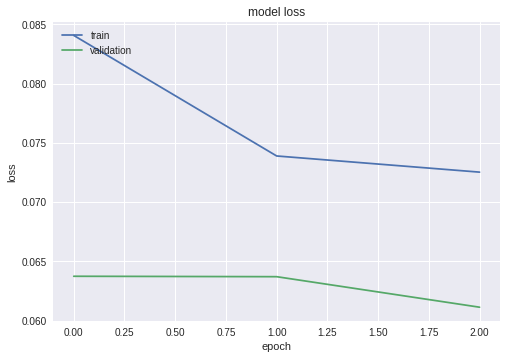

In [0]:
# "Loss"
plt.plot(glove_2_hist.history['loss'])
plt.plot(glove_2_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
glove_2_test_loss, glove_2_test_auc = glove_2_model.evaluate(X_test, y_test, batch_size=32)
print('Test Loss:    ', glove_2_test_loss)
print('Test Accuracy:', glove_2_test_auc)

63978/63978 [==============================] - 209s 3ms/step
Test Loss:     0.08066727316528796
Test Accuracy: 0.9701876617792701


glove+CNN+LSTM


In [0]:
# load the glove6B embedding

embeddings_index = dict()
f = open('/content/data/glove.6B.300d.txt')

for line in f:
    # Note: use split(' ') instead of split() if you get an error
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [0]:
# create a weight matrix
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [0]:
# instantiate pretrained glove model
glove_model_1 = Sequential()

# add embedding layer 
glove_model_1.add(Embedding(input_dim =embedding_matrix.shape[0], input_length=max_len,
                          output_dim=embedding_matrix.shape[1], 
                          weights=[embedding_matrix], trainable=False))
 
# set the dropout layer to drop out 50% of the nodes
glove_model_1.add(SpatialDropout1D(0.5))

# add convolutional layer that has ...
# ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
glove_model_1.add(Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'))

# add bidirectional layer and pass in an LSTM()
glove_model_1.add(Bidirectional(LSTM(25, return_sequences=True)))

# add normalization layer
glove_model_1.add(BatchNormalization())

# add pooling layer 
glove_model_1.add(GlobalMaxPool1D())

# set the dropout layer to drop out 50% of the nodes
glove_model_1.add(Dropout(0.5))

# add dense layer to produce an output dimension of 50 and using relu activation
glove_model_1.add(Dense(50, activation='relu'))

# finally add a dense layer
glove_model_1.add(Dense(6, activation='sigmoid'))


In [0]:
glove_model_1.compile(loss='binary_crossentropy',
                    optimizer=Adam(0.01),
                    metrics=['accuracy'])

glove_model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 300)          63101400  
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 200, 300)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 200, 100)          120100    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200, 50)           25200     
_________________________________________________________________
batch_normalization_5 (Batch (None, 200, 50)           200       
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 50)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
__________

In [0]:
glove_hist_1 = glove_model_1.fit(X_train, y_train, batch_size=32, 
                             epochs=3, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/3
143613/143613 [==============================] - 1905s 13ms/step - loss: 0.0900 - acc: 0.9714 - val_loss: 0.0720 - val_acc: 0.9759
Epoch 2/3
143613/143613 [==============================] - 1708s 12ms/step - loss: 0.0823 - acc: 0.9735 - val_loss: 0.0744 - val_acc: 0.9764
Epoch 3/3
143613/143613 [==============================] - 1743s 12ms/step - loss: 0.0839 - acc: 0.9731 - val_loss: 0.0818 - val_acc: 0.9742


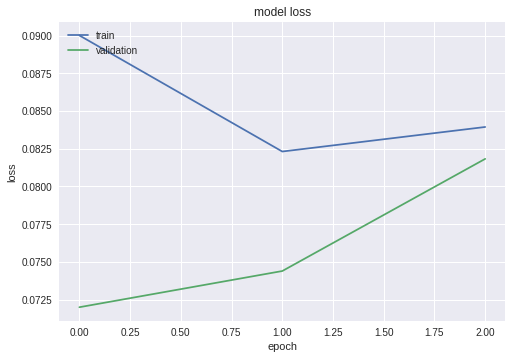

In [0]:
# "Loss"
plt.plot(glove_hist_1.history['loss'])
plt.plot(glove_hist_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

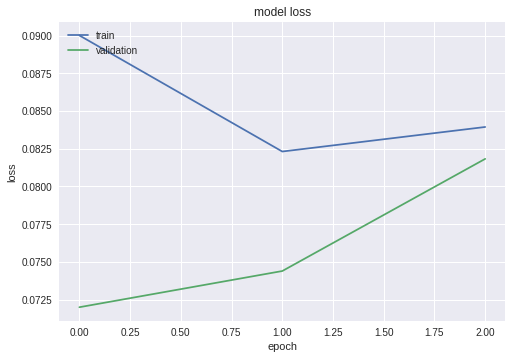

In [0]:
# "Loss"
plt.plot(glove_hist_1.history['loss'])
plt.plot(glove_hist_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
glove_1_test_loss, glove_1_test_auc = glove_model_1.evaluate(X_test, y_test, batch_size=32)
print('Test Loss:    ', glove_1_test_loss)
print('Test Accuracy:', glove_1_test_auc)

63978/63978 [==============================] - 230s 4ms/step
Test Loss:     0.09040789394180744
Test Accuracy: 0.9695259754467467


Conclusions

In [0]:
# concat all training, validation and testing accuracy scores
accuracy_nn = ['Plain NN', 
               np.mean(base_hist.history['acc']), 
               np.mean(base_hist.history['val_acc']), 
               base_test_auc]

accuracy_cnn = ['CNN', 
                np.mean(cnn_hist.history['acc']), 
                np.mean(cnn_hist.history['val_acc']), 
                cnn_test_auc]

accuracy_rnn = ['LSTM', 
                np.mean(rnn_hist.history['acc']), 
                np.mean(rnn_hist.history['val_acc']), 
                rnn_test_auc]

accuracy_glove = ['Glove CNN', 
                  np.mean(glove_hist.history['acc']), 
                  np.mean(glove_hist.history['val_acc']), 
                  glove_test_auc]

accuracy_glove_2 = ['Glove LSTM', 
                    np.mean(glove_2_hist.history['acc']), 
                    np.mean(glove_2_hist.history['val_acc']), 
                    glove_2_test_auc]

accuracy_glove_2 = ['Glove CNN LSTM', 
                    np.mean(glove_hist_1.history['acc']), 
                    np.mean(glove_hist_1.history['val_acc']), 
                    glove_1_test_auc]

# create dataframe
comparison = pd.DataFrame([accuracy_nn])
# append all other scores
comparison = comparison.append([accuracy_cnn, accuracy_rnn, accuracy_glove, accuracy_glove_2])

When we look at the training accuracy, the plain neural network performs best.
When we check the validation accuracy, it's also the plain neural network that stands out.
But when we check how well the models classify unseen data - and therefore check the testing accuracy - it's the pre-trained RNN that does this job with the highest precision.
In this common challenge, it really came down to the decimal places. The winner reached an accuracy score of 0.9877 for a pre-trained embedding - although I'm not certain whether this is a training or validation accuracy. They also used a semi-supervised learning technique called Pseudo-Labelling!

In [0]:
# beautify the new dataframe
comparison.columns = ['Algorithm', 'Training Accuracy', 'Validation Accuracy', 'Testing Accuracy']
comparison.set_index(['Algorithm'], inplace=True)
comparison

,Training Accuracy,Validation Accuracy,Testing Accuracy
Algorithm,,,
Plain NN,0.979456,0.979662,0.971587
CNN,0.978511,0.980163,0.970638
LSTM,0.977480,0.980740,0.971753
Glove CNN,0.975085,0.978583,0.972707
Glove CNN LSTM,0.972660,0.975502,0.969526
